## DataScience NPL: Cyberbullying Tweet Recognization.

## Context

With rise of social media coupled with the Covid-19 pandemic, cyberbullying has reached all time highs. We can combat this by creating
models to automatically flag potentially harmful tweets as well as break down the patterns of hatred

## About Dataset

As social media usage becomes increasingly prevalent in every age group, a vast majority of citizens rely on this essential medium for day-today communication. Social media’s ubiquity means that cyberbullying can effectively impact anyone at any time or anywhere, and the relative anonymity of the internet makes such personal attacks more difficult to stop than traditional bullying.
 
On April 15th, 2020, UNICEF issued a warning in response to the increased risk of cyberbullying during the COVID-19 pandemic due to widespread school closures, increased screen time, and decreased face-to-face social interaction. The statistics of cyberbullying are outright alarming: 36.5% of middle and high school students have felt cyberbullied and 87% have observed cyberbullying, with effects ranging from decreased academic performance to depression to suicidal thoughts.

## Variables

In light of all of this, this dataset contains more than 47000 tweets labelled according to the class of cyberbullying:

**Age**

**Ethnicity**

**Gender**

**Religion**

**Other type of cyberbullying**

**Not cyberbullying**

## Objective 

The objective of this project is to create a model that can automatically flag potentially harmful tweets as break down the patters of hatred

## Importing Libraries

In [197]:
# pip install emoji -2.2.0
# pip install wordcloud-1.8.2.2

In [198]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import emoji
import string 
import nltk
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import pickle
import jinja2

## Getting Data

In [199]:
data=pd.read_csv("D:\IBM_Data_Science\Data_set\cyberbullying_tweets.csv\cyberbullying_tweets.csv")

In [200]:
data.head(5)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


## Initial Review

In [201]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


## Checking Missing Values

In [202]:
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

## No Missing Values Found!

In [203]:
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

## Renaming columns for better understanding

In [204]:
data=data.rename(columns={'tweet_text':'text','cyberbullying_type':'sentiment'})

In [205]:
data.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


## Adding encoded column for sentiments

In [206]:
data["sentiment_encoded"] = data['sentiment'].replace({"religion": 1, "age": 2, "ethnicity": 3, "gender": 4, "other_cyberbullying":5})

In [207]:
data.head()

,text,sentiment,sentiment_encoded
0,"In other words #katandandre, your food was cra...",not_cyberbullying,not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,not_cyberbullying


In [208]:
stop_words = set(stopwords.words('english'))

## Preprocessing of Text

### Function To Remove Emojis

In [209]:
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

**Function to Convert text to lowercase, remove(/r,/n characters),URLs, non-utf character, Numbers,punctuations, stopwords**

In [210]:
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopchars= string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

## Function to remove contraictions


In [211]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

## Function to Clean Hashtags

In [212]:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

## Function to Filter Special Characters such as $, &

In [213]:
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)


## Function to remove mutiple sequence spaces

In [214]:
def remove_mult_spaces(text):
    return re.sub("\s\s+"," ",text)

## Function to apply stemming to words

In [215]:
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

## Function to apply lemmatization to words

In [216]:
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

## Function to Preprocess the text by applying all above functions

In [217]:
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    return text

In [218]:
# import nltk
# nltk.download('punkt')

In [219]:
data['cleaned_text'] = data['text'].apply(preprocess)
data.head()

,text,sentiment,sentiment_encoded,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,not_cyberbullying,isi account pretend kurdish account like islam...


## Clearned text added

## Dealing with Duplicates

In [220]:
data['cleaned_text'].duplicated().sum()

3041

In [221]:
data.drop_duplicates("cleaned_text",inplace=True)

## Duplicates removed

## Tokenization

In [222]:
data['tweet_list']=data['cleaned_text'].apply(word_tokenize)

In [223]:
data.head(5)

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list
0,"In other words #katandandre, your food was cra...",not_cyberbullying,not_cyberbullying,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,not_cyberbullying,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,not_cyberbullying,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,not_cyberbullying,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like..."


## checking length of various tweet texts

In [224]:
text_len=[]
for text in data.tweet_list:
    tweet_len=len(text)
    text_len.append(tweet_len)
data['text_len']=text_len

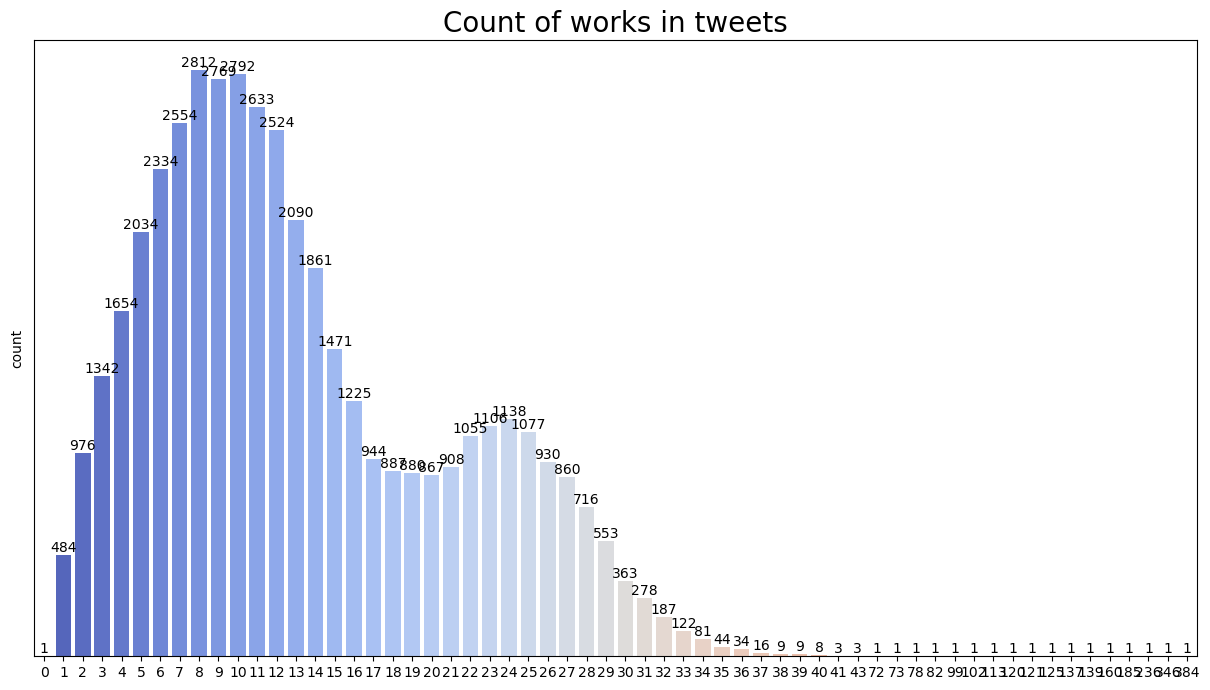

In [225]:
plt.figure(figsize=(15,8))
ax=sns.countplot(x='text_len',data=data,palette='coolwarm')
plt.title("Count of works in tweets", fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel("count")
plt.xlabel("")
plt.show()

## Removing text without words

In [226]:
data=data[data['text_len']!=0]

In [227]:
data.shape

(44650, 6)

## Function to create Word Cloud


In [228]:
def plot_wordcloud(cyberbullying_type):
    string = ""
    for i in data[data.sentiment == cyberbullying_type].cleaned_text.values:
        string = string + " " + i.strip()
    custom_mask = np.array(Image.open("D:\\UEL\\v65oai7fxn47qv9nectx.png"))
    mask_colors = ImageColorGenerator(custom_mask)
    wordcloud = WordCloud(background_color ='white',max_words=2000, max_font_size=256,
                random_state=42, width=custom_mask.shape[1],height=custom_mask.shape[0],
                mask = custom_mask,min_font_size = 10,color_func=mask_colors).generate(string)
# plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(cyberbullying_type)
    plt.show()
    del string

## Splitting data based on sentiment for Data Exploration

In [229]:
not_cyberbullying_type = data[data['sentiment']=='not_cyberbullying']
gender_type = data[data['sentiment']=='gender']
religion_type = data[data['sentiment']=='religion']
other_cyberbullying_type = data[data['sentiment']=='other_cyberbullying']
age_type = data[data['sentiment']=='age']
ethnicity_type = data[data['sentiment']=='ethnicity']

## Exploratory Data Analysis

## Gender Based Cyberbullying

In [230]:
gender = Counter([item for sublist in gender_type['tweet_list'] for item in sublist])
top20_gender = pd.DataFrame(gender.most_common(20))
top20_gender.columns = ['Top Words','Count']
top20_gender.style.background_gradient(cmap='Greens')

,Top Words,Count
0,joke,5179
1,rape,4070
2,gay,3852
3,call,1401
4,make,1283
5,rt,1221
6,woman,1182
7,bitch,1146
8,femal,1108
9,peopl,988


Text(0.5, 1.0, 'Top 20 Words in Gender Cyberbullying')

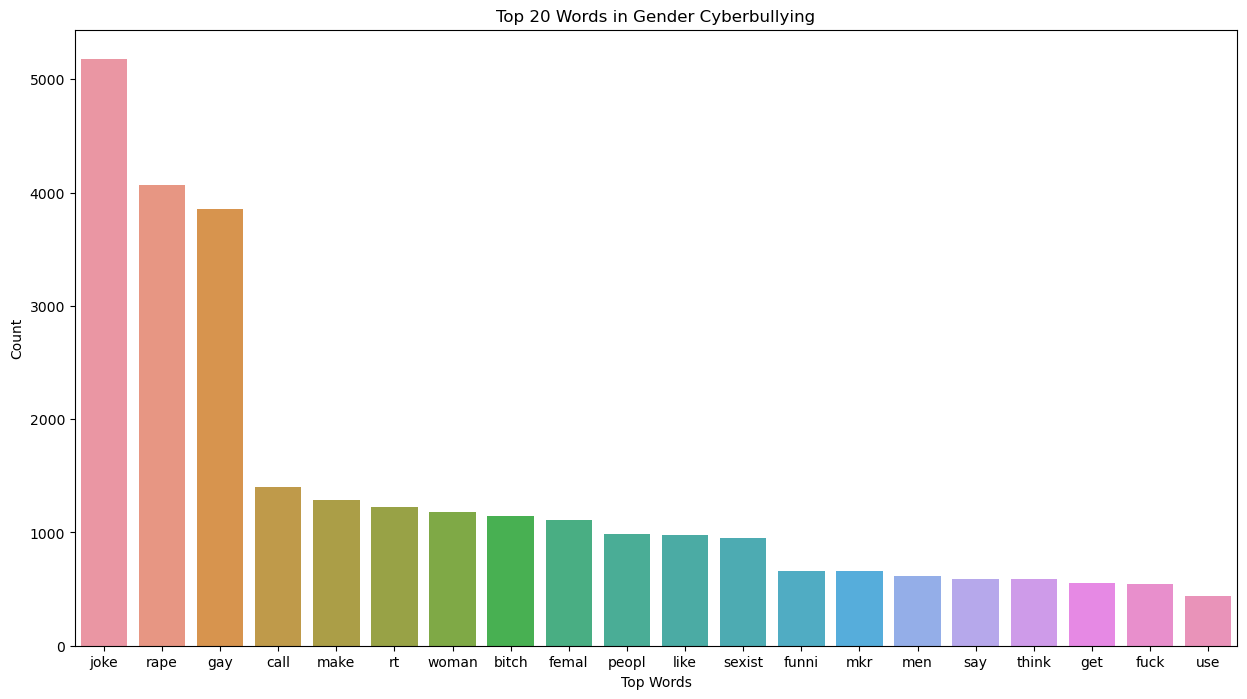

In [231]:
fig=plt.figure(figsize=(15,8))
sns.barplot(data=top20_gender,y='Count',x='Top Words')
plt.title("Top 20 Words in Gender Cyberbullying")

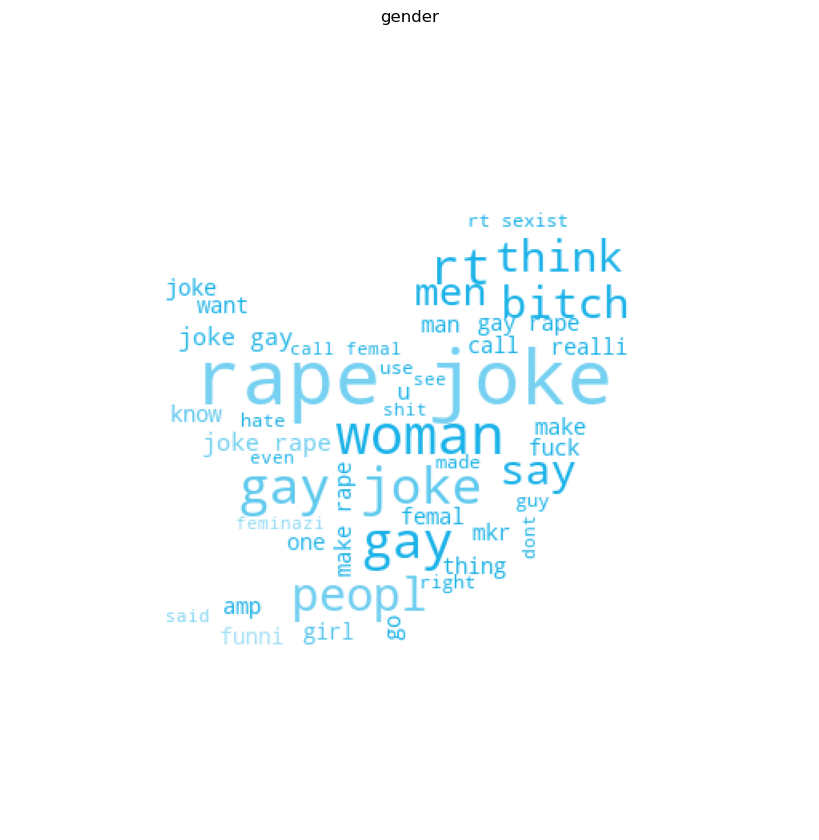

In [232]:
plot_wordcloud('gender')

## Religion Based Cyberbullying

In [233]:
religion=Counter([item for sublist in religion_type['tweet_list'] for item in sublist])
top20_religion=pd.DataFrame(religion.most_common(20))
top20_religion.columns=['Top Words',"Count"]
top20_religion.style.background_gradient(cmap="Greens")

,Top Words,Count
0,muslim,4618
1,idiot,3075
2,islam,2440
3,christian,2132
4,u,1922
5,terrorist,1378
6,right,1289
7,like,1276
8,support,1251
9,woman,1247


Text(0.5, 1.0, 'Top 20 words in Religion Cyberbullying')

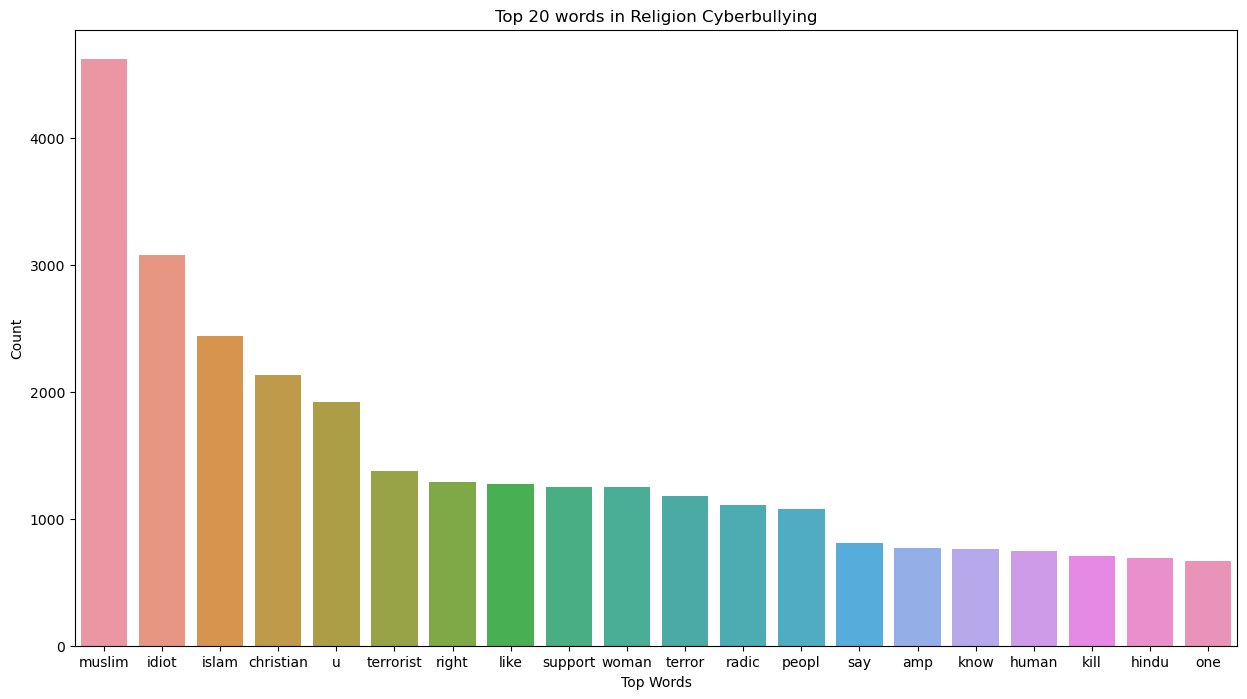

In [234]:
fig=plt.figure(figsize=(15,8))
sns.barplot(data=top20_religion,y="Count",x="Top Words")
plt.title("Top 20 words in Religion Cyberbullying")

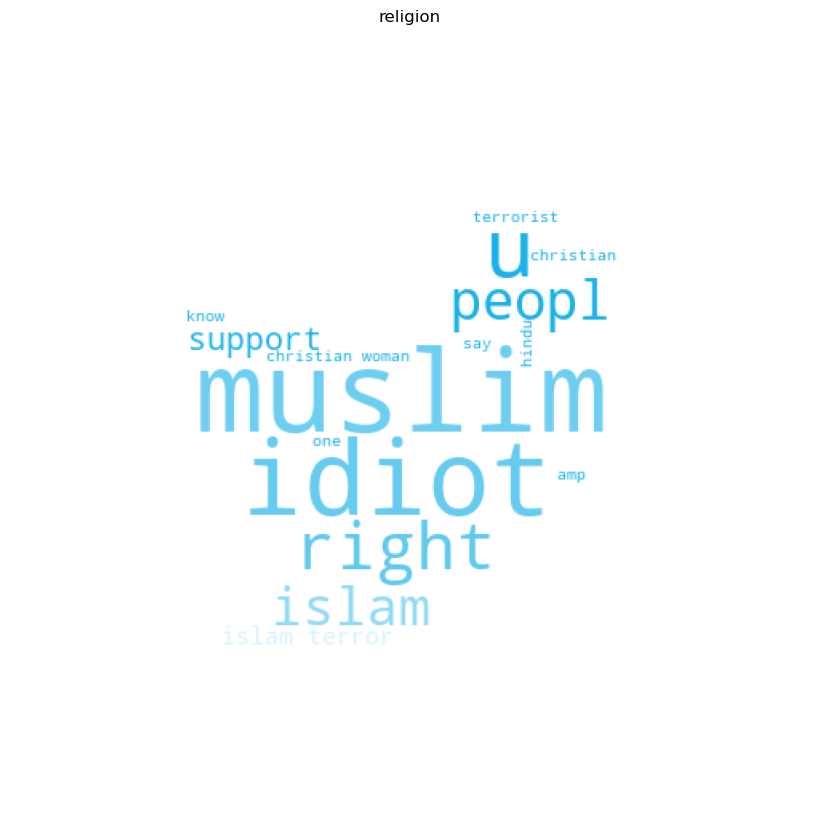

In [235]:
plot_wordcloud("religion")

## Age based Cyberbullying

In [236]:
age=Counter([item for sublist in age_type['tweet_list'] for item in sublist])
top20_age=pd.DataFrame(age.most_common(20))
top20_age.columns=['Top Words',"Count"]
top20_age.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,8899
1,school,8426
2,high,4861
3,girl,4616
4,like,2076
5,get,1051
6,one,1044
7,peopl,934
8,got,842
9,kid,809


Text(0.5, 1.0, 'Top 20 words in Age Cyberbullying')

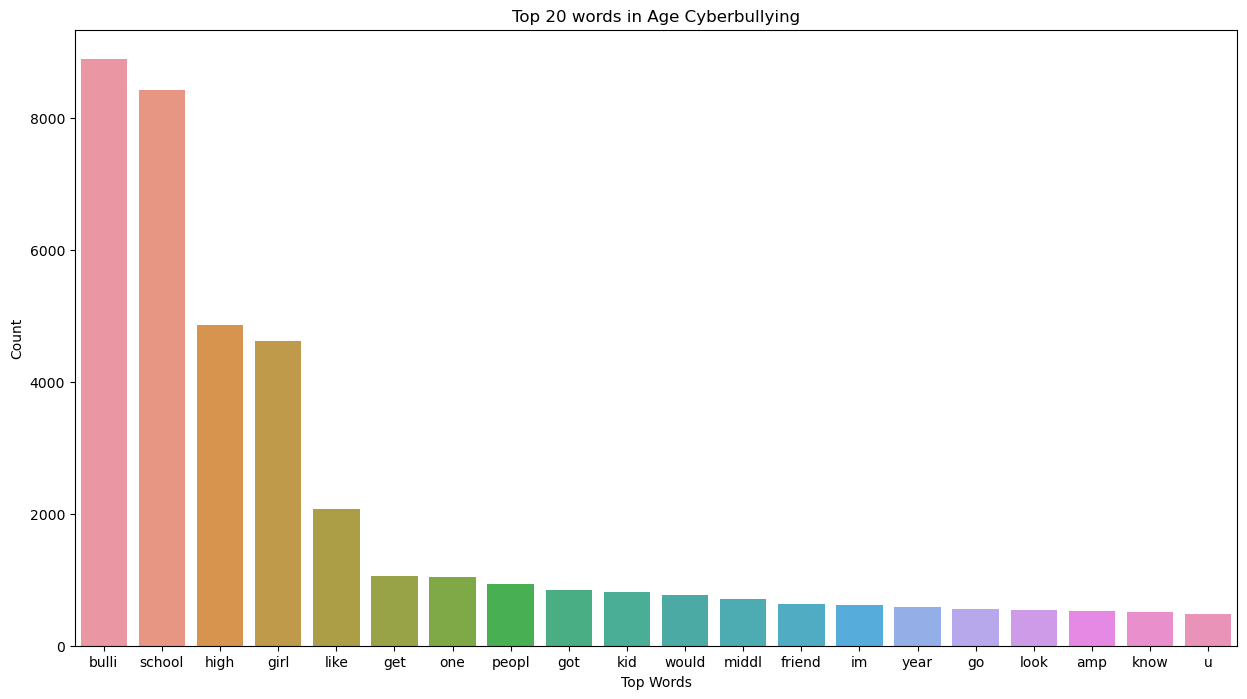

In [237]:
fig=plt.figure(figsize=(15,8))
sns.barplot(data=top20_age,y='Count',x='Top Words')
plt.title("Top 20 words in Age Cyberbullying")

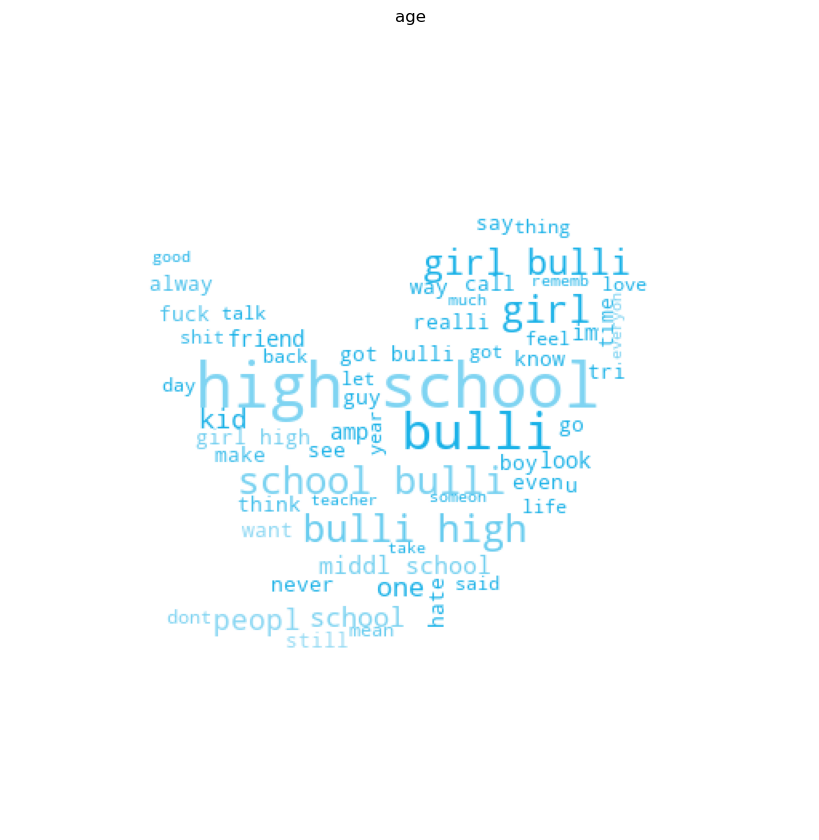

In [238]:
plot_wordcloud('age')

## Ethnicity based Cyberbullying 

In [239]:
ethnicity=Counter([item for sublist in ethnicity_type['tweet_list'] for item in sublist])
top20_ethnicity=pd.DataFrame(ethnicity.most_common(20))
                             
top20_ethnicity.columns=['Top Words','Count']
top20_ethnicity.style.background_gradient(cmap='Greens')

,Top Words,Count
0,fuck,5892
1,nigger,5456
2,dumb,5003
3,as,2241
4,black,2134
5,u,2107
6,white,1557
7,call,1381
8,peopl,1182
9,rt,1166


Text(0.5, 1.0, 'Top 20 words in Ethnicity Cyberbullying')

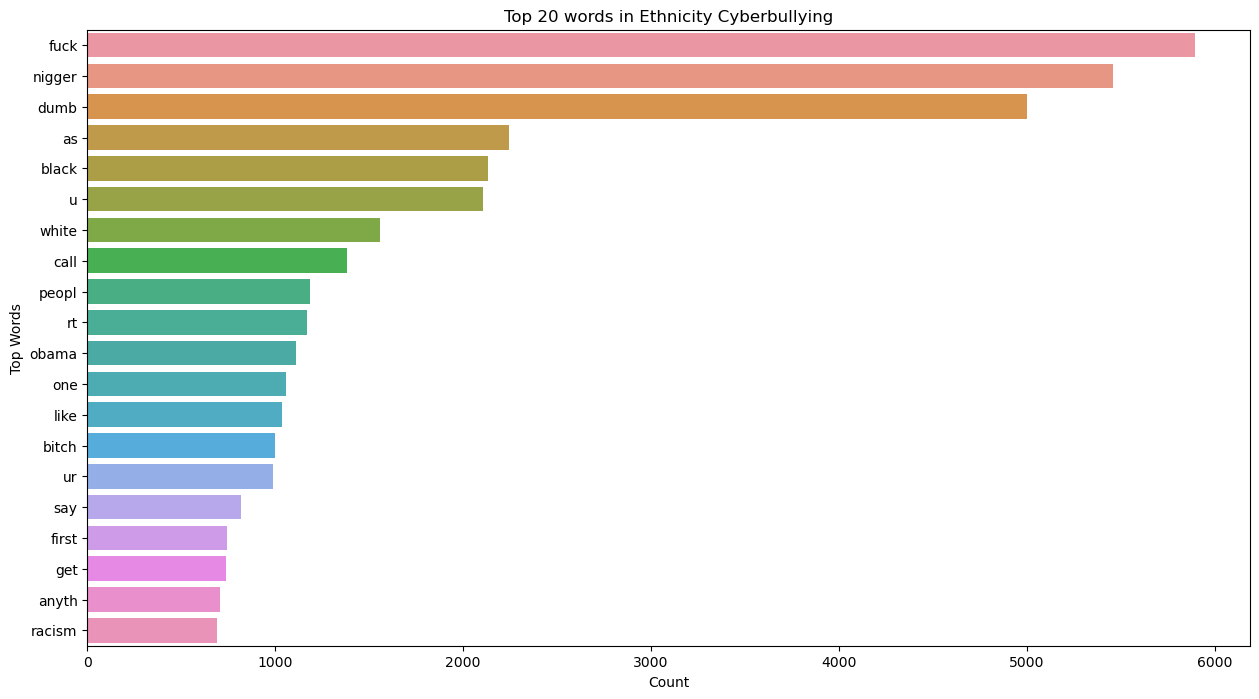

In [240]:
fig=plt.figure(figsize=(15,8))
sns.barplot(data=top20_ethnicity,x='Count',y="Top Words")
plt.title("Top 20 words in Ethnicity Cyberbullying")

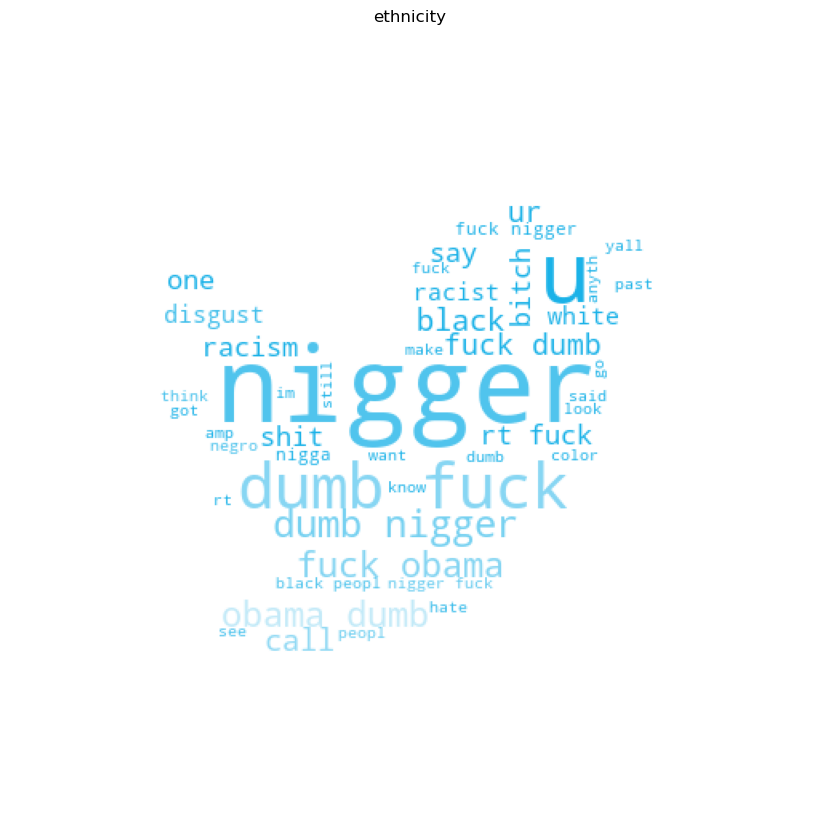

In [241]:
plot_wordcloud('ethnicity')

## Other types of Cyberbullying

In [242]:
other_cyberbullying = Counter([item for sublist in other_cyberbullying_type['tweet_list'] for item in sublist])
top20_other_cyberbullying = pd.DataFrame(other_cyberbullying.most_common(20))
top20_other_cyberbullying.columns = ['Top Words','Count']
top20_other_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,bulli,882
1,rt,727
2,fuck,509
3,like,424
4,get,393
5,peopl,353
6,go,277
7,idiot,261
8,know,241
9,think,237


Text(0.5, 1.0, 'Top 20 words in Other Cyberbullying')

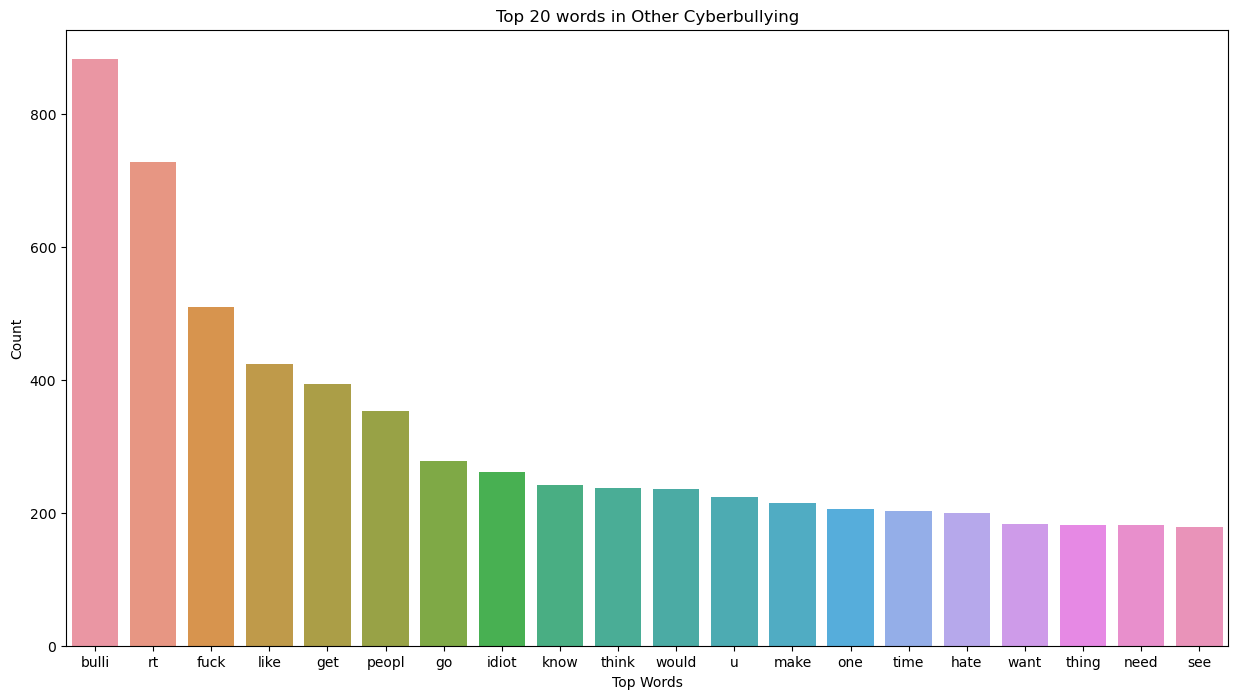

In [243]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_other_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Other Cyberbullying")

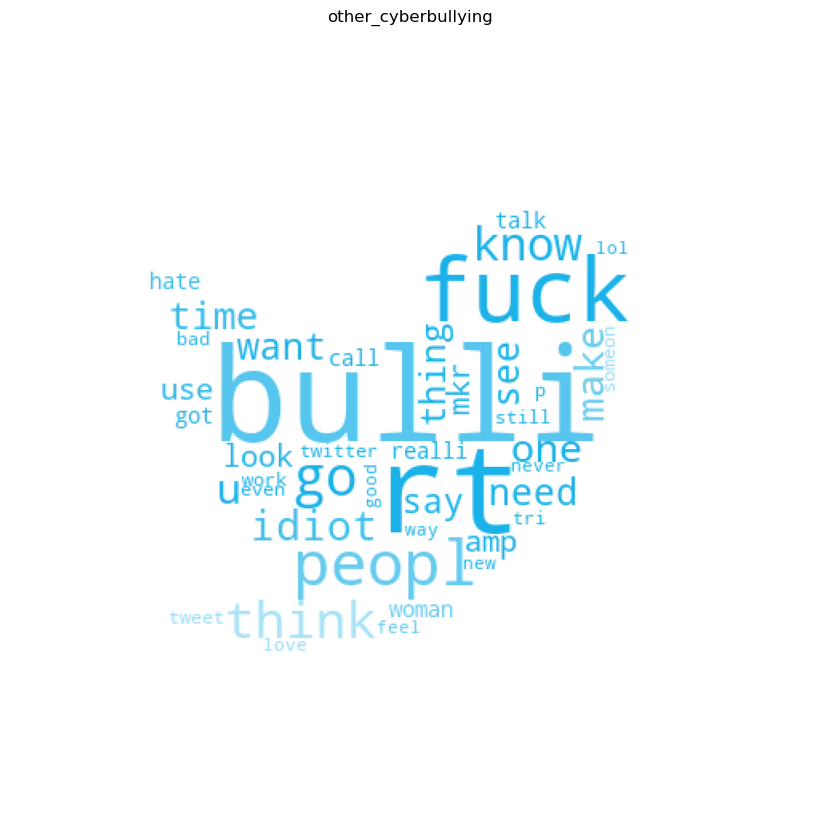

In [244]:
plot_wordcloud('other_cyberbullying')

## Tweets without Cyberbullying

In [245]:
not_cyberbullying = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
top20_not_cyberbullying = pd.DataFrame(not_cyberbullying.most_common(20))
top20_not_cyberbullying.columns = ['Top Words','Count']
top20_not_cyberbullying.style.background_gradient(cmap='Greens')

,Top Words,Count
0,mkr,1674
1,bulli,1102
2,rt,785
3,like,424
4,get,423
5,go,394
6,school,374
7,kat,286
8,would,286
9,peopl,272


Text(0.5, 1.0, 'Top 20 words in Not Cyberbullying')

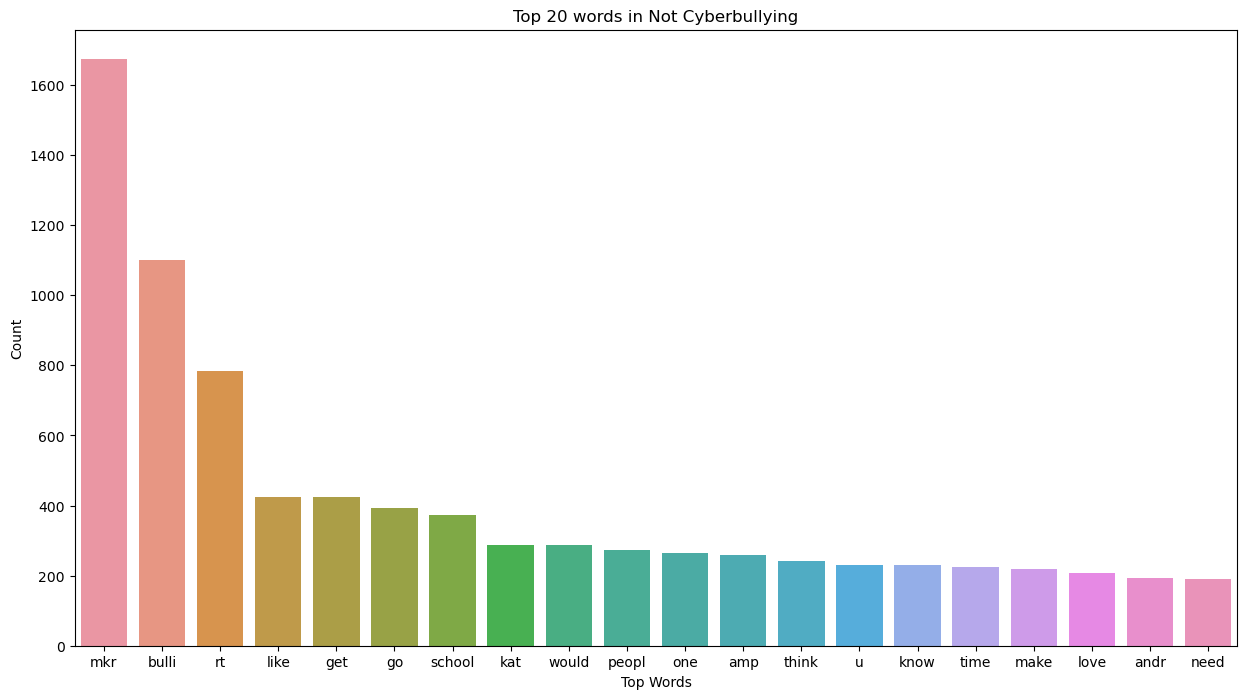

In [246]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top20_not_cyberbullying, y="Count", x="Top Words")
plt.title("Top 20 words in Not Cyberbullying")

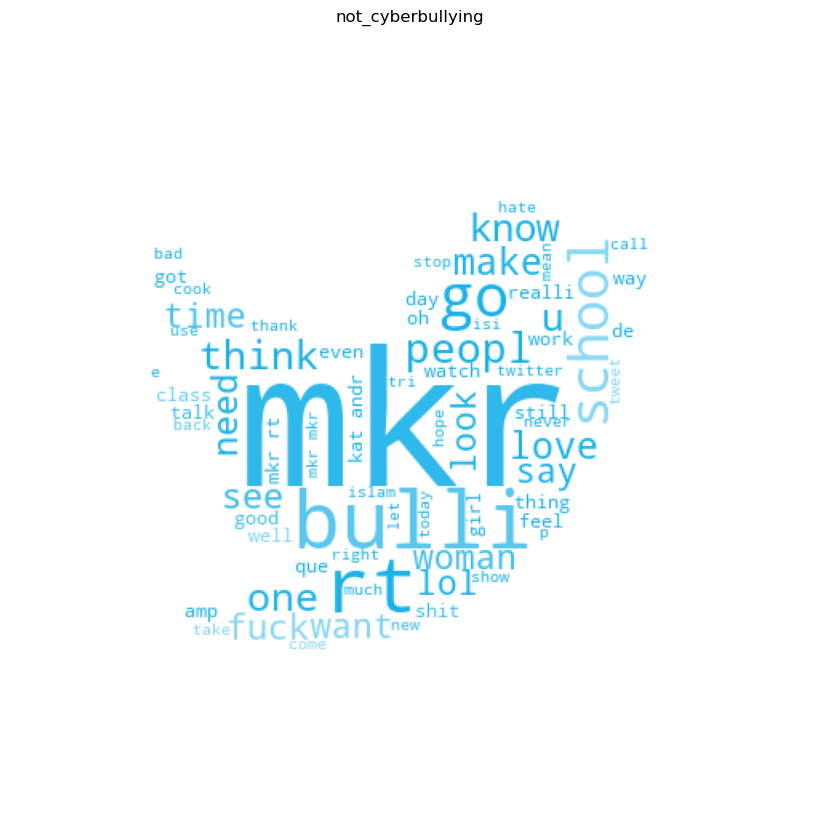

In [247]:
plot_wordcloud('not_cyberbullying')

In [248]:
data.head()

,text,sentiment,sentiment_encoded,cleaned_text,tweet_list,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,not_cyberbullying,word katandandr food crapilici mkr,"[word, katandandr, food, crapilici, mkr]",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,not_cyberbullying,classi whore red velvet cupcak,"[classi, whore, red, velvet, cupcak]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,not_cyberbullying,meh p thank head concern anoth angri dude twitter,"[meh, p, thank, head, concern, anoth, angri, d...",9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,not_cyberbullying,isi account pretend kurdish account like islam...,"[isi, account, pretend, kurdish, account, like...",8


In [249]:
sentiments = ["religion", "age", "ethnicity", "gender", "other_cyberbullying","not_cyberbullying"]

## Splitting Data into Train and Test Sets

In [250]:
X,y = data['cleaned_text'],data['sentiment_encoded']

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(29915,) (29915,) (14735,) (14735,)


## tf-idf Vectorization

In [252]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)
print(X_train_tf.shape)
print(X_test_tf.shape)

(29915, 28535)
(14735, 28535)


## Logistic Regression

In [253]:
log_reg= LogisticRegression()

In [254]:
log_cv_score = cross_val_score(log_reg,X_train_tf,y_train,cv=5,scoring='f1_macro',n_jobs=-1)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1204, in fit
    check_classification_targets(y)
  File "C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\utils\multiclass.py", line 207, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'unknown'


In [ ]:
mean_log_cv = np.mean(log_cv_score)
mean_log_cv